In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install patchify==0.2.3

In [ ]:
import numpy as np
import tensorflow as tf

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [ ]:

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

from math import log2
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model

def mlp(x, cf):
    x = L.Dense(cf["mlp_dim"], activation="gelu")(x)
    x = L.Dropout(cf["dropout_rate"])(x)
    x = L.Dense(cf["hidden_dim"])(x)
    x = L.Dropout(cf["dropout_rate"])(x)
    return x

def transformer_encoder(x, cf):
    skip_1 = x
    x = L.LayerNormalization()(x)
    x = L.MultiHeadAttention(
        num_heads=cf["num_heads"], key_dim=cf["hidden_dim"])(x, x)
    x = L.Add()([x, skip_1])

    skip_2 = x
    x = L.LayerNormalization()(x)
    x = mlp(x, cf)
    x = L.Add()([x, skip_2])

    return x

def conv_block(x, num_filters, kernel_size=3):
    x = L.Conv2D(num_filters, kernel_size=kernel_size, padding="same")(x)
    x = L.BatchNormalization()(x)
    x = L.ReLU()(x)
    return x

def deconv_block(x, num_filters, strides=2):
    x = L.Conv2DTranspose(num_filters, kernel_size=2, padding="same", strides=strides)(x)
    return x

def build_unetr_2d(cf):
    """ Inputs """
    input_shape = (cf["num_patches"], cf["patch_size"]*cf["patch_size"]*cf["num_channels"])
    inputs = L.Input(input_shape)


    """ Patch + Position Embeddings """
    patch_embed = L.Dense(cf["hidden_dim"])(inputs)
    positions = tf.range(start=0, limit=cf["num_patches"], delta=1)

    pos_embed = L.Embedding(input_dim=cf["num_patches"], output_dim=cf["hidden_dim"])(positions)
    x = patch_embed + pos_embed

    """ Transformer Encoder """
    skip_connection_index = [3, 6, 9, 12]
    skip_connections = []

    for i in range(1, cf["num_layers"]+1, 1):
        x = transformer_encoder(x, cf)

        if i in skip_connection_index:
            skip_connections.append(x)

    """ CNN Decoder """
    z3, z6, z9, z12 = skip_connections

    ## Reshaping
    z0 = L.Reshape((cf["image_size"], cf["image_size"], cf["num_channels"]))(inputs)

    shape = (
        cf["image_size"]//cf["patch_size"],
        cf["image_size"]//cf["patch_size"],
        cf["hidden_dim"]
    )

    # print("Skip connections")
    z3 = L.Reshape(shape)(z3)
    z6 = L.Reshape(shape)(z6)
    # print(z6.shape)
    z9 = L.Reshape(shape)(z9)
    # print(z9.shape)
    z12 = L.Reshape(shape)(z12)
    # print(z12.shape)

    ## Additional layers for managing different patch sizes
    total_upscale_factor = int(log2(cf["patch_size"]))
    upscale = total_upscale_factor - 4

    if upscale >= 2: ## Patch size 16 or greater
        z3 = deconv_block(z3, z3.shape[-1], strides=2**upscale)
        z6 = deconv_block(z6, z6.shape[-1], strides=2**upscale)
        z9 = deconv_block(z9, z9.shape[-1], strides=2**upscale)
        z12 = deconv_block(z12, z12.shape[-1], strides=2**upscale)
        print(z3.shape, z6.shape, z9.shape, z12.shape)

    if upscale < 0: ## Patch size less than 16
        p = 2**abs(upscale)
        z3 = L.MaxPool2D((p, p))(z3)
        z6 = L.MaxPool2D((p, p))(z6)
        z9 = L.MaxPool2D((p, p))(z9)
        z12 = L.MaxPool2D((p, p))(z12)

    # print(z3, z6, z9, z12)
    # print(x.shape)
    ## Decoder 1
    x = deconv_block(z12, 512)
    # print(x.shape, "Decoder 1")

    s = deconv_block(z9, 512)
    # print(s.shape, "z9 deconv")
    s = conv_block(s, 512)
    # print(s.shape, "z9 conv")

    x = L.Concatenate()([x, s])

    # print(x.shape, "z9 z12 concat")

    x = conv_block(x, 512)
    # print(x.shape, "conv")
    x = conv_block(x, 512)
    # print(x.shape, "conv")

    ## Decoder 2
    x = deconv_block(x, 256)
    # print(x.shape, "decoder 2")

    #5
    s = deconv_block(z6, 256)
    # print(s.shape, "z6 deconv")
    s = conv_block(s, 256)
    # print(s.shape, "z6 conv")
    s = deconv_block(s, 256)
    # print(s.shape, "z6 deconv")
    s = conv_block(s, 256)
    # print(s.shape, "z6 conv")

    x = L.Concatenate()([x, s])
    # print(x.shape, "z6 z9 concat")

    #6
    x = conv_block(x, 256)
    # print(x.shape, "conv")
    x = conv_block(x, 256)
    # print(x.shape, "conv")

    #7
    x = deconv_block(x, 128)
    # print(x.shape, "decoder 3")



    #8
    s = deconv_block(z3, 128)
    # print(s.shape, "z3 deconv")
    s = conv_block(s, 128)
    # print(s.shape, "z3 conv")
    s = deconv_block(s, 128)
    # print(s.shape, "z3 deconv")
    s = conv_block(s, 128)
    # print(s.shape, "z3 conv")
    s = deconv_block(s, 128)
    # print(s.shape, "z3 deconv")
    s = conv_block(s, 128)
    # print(s.shape, "z3 conv")

    x = L.Concatenate()([x, s])
    # print(x.shape, "z3 z6 concat")

    #9
    x = conv_block(x, 128)
    # print(x.shape)
    x = conv_block(x, 128)
    # print(x.shape)


    ## Decoder 4
    x = deconv_block(x, 64)
    # print(x.shape, "deconv 4")

    s = conv_block(z0, 64)
    # print(s.shape, "z0 conv")
    s = conv_block(s, 64)
    # print(s.shape, "z0 conv")


    x = L.Concatenate()([x, s])
    # print(x.shape , "z0 z3 concat")

    x = conv_block(x, 64)
    # print(x.shape)
    x = conv_block(x, 64)
    # print(x.shape)

    """ Output """
    outputs = L.Conv2D(1, kernel_size=1, padding="same", activation="sigmoid")(x)
    # print(outputs.shape)

    return Model(inputs, outputs, name="UNETR_2D")

if __name__ == "__main__":
    # config = {}
    # config["image_size"] = 512
    # config["num_layers"] = 12
    # config["hidden_dim"] = 64
    # config["mlp_dim"] = 128
    # config["num_heads"] = 6
    # config["dropout_rate"] = 0.1
    # config["patch_size"] = 1
    # config["num_patches"] = (config["image_size"]**2)//(config["patch_size"]**2)
    # config["num_channels"] = 3

  cf = {}
  # cf["image_size"] = 512
  cf["image_size"] = 256
  cf["num_channels"] = 3
  cf["num_layers"] = 12
  cf["hidden_dim"] = 768
  # cf["mlp_dim"] = 32
  cf["mlp_dim"] = 3072
  cf["num_heads"] = 6
  cf["dropout_rate"] = 0.1
  cf["patch_size"] = 16
  cf["num_patches"] = (cf["image_size"]**2)//(cf["patch_size"]**2)
  cf["flat_patches_shape"] = (
      cf["num_patches"],
      cf["patch_size"]*cf["patch_size"]*cf["num_channels"])

  model = build_unetr_2d(cf)
  model.summary()

transformer  (None, 256, 768)


Model: "UNETR_2D"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 768)       │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256, 768)       │        590,592 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 256, 768)       │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 256, 768)       │          1,536 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 256, 768)       │     14,170,368 │ layer_normalization[0… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 256, 768)       │              0 │ multi_head_attention[… │
│                           │                        │                │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 256, 768)       │          1,536 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256, 3072)      │      2,362,368 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 256, 3072)      │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 256, 768)       │      2,360,064 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 256, 768)       │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 256, 768)       │              0 │ dropout_2[0][0],       │
│                           │                        │                │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 256, 768)       │          1,536 │ add_2[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 256, 768)       │     14,170,368 │ layer_normalization_2… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_3 (Add)               │ (None, 256, 768)       │              0 │ multi_head_attention_… │
│                           │                        │                │ add_2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_3

 Total params: 246,187,713 (939.13 MB)

 Trainable params: 246,180,801 (939.11 MB)

 Non-trainable params: 6,912 (27.00 KB)

In [ ]:
import cv2
import numpy as np
import os
from glob import glob
from sklearn.model_selection import train_test_split
from patchify import patchify


In [ ]:

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def load_dataset(path, split=0.2):
    """ Loading the images and masks """
    X = sorted(glob(os.path.join(path, "aug_img", "*.png")))
    Y = sorted(glob(os.path.join(path, "aug_masks", "*.png")))

    """ Spliting the data into training and testing """
    split_size = int(len(X) * split)

    train_x, valid_x = train_test_split(X, test_size=split_size, random_state=42)
    train_y, valid_y = train_test_split(Y, test_size=split_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=split_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

def read_image(path):
    path = path.decode()
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (cf["image_size"], cf["image_size"]))
    image = image / 255.0 # Normalizing the pixel values

    # print("Image : ", image)

    # # Separate channels
    # red_channel = image[:, :, 0]
    # green_channel = image[:, :, 1]
    # blue_channel = image[:, :, 2]
    # print("Red channel", red_channel)
    # print("Green channel ", green_channel)
    # print("Blue channel", blue_channel)

    """ Processing to patches """
    patch_shape = (cf["patch_size"], cf["patch_size"], cf["num_channels"])
    patches = patchify(image, patch_shape, cf["patch_size"])
    # print("First patch", patches[0])
    patches = np.reshape(patches, cf["flat_patches_shape"])
    # print("Patches shape", patches.shape)
    patches = patches.astype(np.float32)

    return patches

def read_mask(path):
    path = path.decode()
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (cf["image_size"], cf["image_size"]))
    mask = mask / 255.0
    mask = mask.astype(np.float32)
    mask = np.expand_dims(mask, axis=-1)
    return mask

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape(cf["flat_patches_shape"])
    y.set_shape([cf["image_size"], cf["image_size"], 1])
    return x, y

def tf_dataset(X, Y, batch=2):
    ds = tf.data.Dataset.from_tensor_slices((X, Y))
    ds = ds.map(tf_parse).batch(batch).prefetch(10)
    return ds

In [ ]:
read_image(b"/content/drive/MyDrive/aug_img/ID_0000_Z_0142_90.png")


array([[0.05882353, 0.05882353, 0.05882353, ..., 0.07450981, 0.07450981,
        0.07450981],
       [0.0627451 , 0.0627451 , 0.0627451 , ..., 0.05098039, 0.05098039,
        0.05098039],
       [0.06666667, 0.06666667, 0.06666667, ..., 0.05882353, 0.05882353,
        0.05882353],
       ...,
       [0.10196079, 0.10196079, 0.10196079, ..., 0.07058824, 0.07058824,
        0.07058824],
       [0.09019608, 0.09019608, 0.09019608, ..., 0.06666667, 0.06666667,
        0.06666667],
       [0.09019608, 0.09019608, 0.09019608, ..., 0.07058824, 0.07058824,
        0.07058824]], dtype=float32)

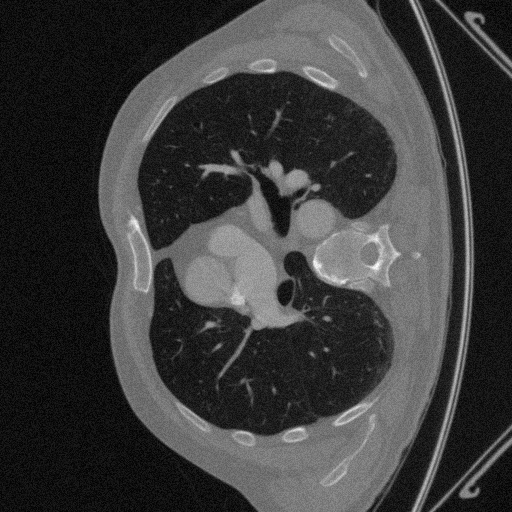

In [ ]:
from google.colab.patches import cv2_imshow
image = cv2.imread('/content/drive/MyDrive/aug_img/ID_0000_Z_0142_90.png', cv2.IMREAD_COLOR)
cv2_imshow( image)

In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.model_selection import train_test_split
from patchify import patchify



""" UNETR  Configration """
cf = {}
cf["image_size"] = 256
# cf["image_size"] = 512
cf["num_channels"] = 3
cf["num_layers"] = 12
cf["hidden_dim"] = 768
cf["mlp_dim"] = 32
# cf["num_heads"] = 6
cf["num_heads"] = 4
cf["dropout_rate"] = 0.1
cf["patch_size"] = 16
cf["num_patches"] = (cf["image_size"]**2)//(cf["patch_size"]**2) #256
cf["flat_patches_shape"] = (
    cf["num_patches"],
    cf["patch_size"]*cf["patch_size"]*cf["num_channels"]
)
#(16, 768)




if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Directory for storing files """
    create_dir("/content/drive/MyDrive/files3")

    """ Hyperparameters """
    batch_size = 8 #16
    lr = 0.1
    num_epochs = 500
    model_path = os.path.join("/content/drive/MyDrive/files3", "model.keras")
    csv_path = os.path.join("/content/drive/MyDrive/files3", "log.csv")

    """ Dataset """
    dataset_path = "/content/drive/MyDrive"
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset(dataset_path)

    print(f"Train: \t{len(train_x)} - {len(train_y)}")

    print(f"Valid: \t{len(valid_x)} - {len(valid_y)}")
    print(f"Test: \t{len(test_x)} - {len(test_y)}")

    train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
    valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

    """ Model """
    model = build_unetr_2d(cf)
    model.compile(loss=dice_loss, optimizer=SGD(lr), metrics=[dice_coef, "acc"])
    # model.summary()

    callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
        CSVLogger(csv_path),
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False)
    ]

    model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=valid_dataset,
        callbacks=callbacks
    )

Train: 	642 - 642
Valid: 	213 - 213
Test: 	213 - 213
transformer  (None, 256, 768)
Epoch 1/500
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - acc: 0.5324 - dice_coef: 0.4130 - loss: 0.5870
Epoch 1: val_loss improved from inf to 0.69277, saving model to /content/drive/MyDrive/files3/model.keras
81/81 ━━━━━━━━━━━━━━━━━━━━ 570s 6s/step - acc: 0.5330 - dice_coef: 0.4136 - loss: 0.5864 - val_acc: 0.7678 - val_dice_coef: 0.3074 - val_loss: 0.6928 - learning_rate: 0.1000
Epoch 2/500
10/81 ━━━━━━━━━━━━━━━━━━━━ 58s 824ms/step - acc: 0.7369 - dice_coef: 0.5787 - loss: 0.4213

In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

from sklearn.metrics import f1_score, jaccard_score, precision_score, recall_score


import numpy as np
import cv2
from tqdm import tqdm
import tensorflow as tf
from patchify import patchify



""" UNETR  Configration """
cf = {}
cf["image_size"] = 256
cf["num_channels"] = 3
cf["num_layers"] = 12
cf["hidden_dim"] = 128
cf["mlp_dim"] = 32
cf["num_heads"] = 6
cf["dropout_rate"] = 0.1
cf["patch_size"] = 16
cf["num_patches"] = (cf["image_size"]**2)//(cf["patch_size"]**2)
cf["flat_patches_shape"] = (
    cf["num_patches"],
    cf["patch_size"]*cf["patch_size"]*cf["num_channels"]
)


if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Directory for storing files """
    create_dir("/content/drive/MyDrive/results")

    """ Load the model """
    model_path = os.path.join("/content/drive/MyDrive/files2", "model.keras")
    model = tf.keras.models.load_model(model_path, custom_objects={"dice_loss": dice_loss, "dice_coef": dice_coef})

    """ Dataset """
    dataset_path = "/content/drive/MyDrive"
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset(dataset_path)

    print(f"Train: \t{len(train_x)} - {len(train_y)}")
    print(f"Valid: \t{len(valid_x)} - {len(valid_y)}")
    print(f"Test: \t{len(test_x)} - {len(test_y)}")

    """ Prediction """
    SCORE = []
    for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
        """ Extracting the name """
        name = x.split("/")[-1]

        """ Reading the image """
        image = cv2.imread(x, cv2.IMREAD_COLOR)
        image = cv2.resize(image, (cf["image_size"], cf["image_size"]))
        x = image / 255.0

        patch_shape = (cf["patch_size"], cf["patch_size"], cf["num_channels"])
        patches = patchify(x, patch_shape, cf["patch_size"])
        patches = np.reshape(patches, cf["flat_patches_shape"])
        patches = patches.astype(np.float32)
        patches = np.expand_dims(patches, axis=0)

        """ Read Mask """
        mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (cf["image_size"], cf["image_size"]))
        mask = mask / 255.0
        mask = np.expand_dims(mask, axis=-1)
        mask = np.concatenate([mask, mask, mask], axis=-1)

        """ Prediction """
        pred = model.predict(patches, verbose=0)[0]
        pred = np.concatenate([pred, pred, pred], axis=-1)



        """ Save final mask """
        line = np.ones((cf["image_size"], 10, 3)) * 255
        cat_images = np.concatenate([image, line, mask*255, line, pred*255], axis=1)
        save_image_path = os.path.join("/content/drive/MyDrive/results",  name)
        cv2.imwrite(save_image_path, cat_images)






In [ ]:
import os
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import f1_score, precision_score, recall_score, jaccard_score
from tensorflow.keras.utils import CustomObjectScope
import tensorflow as tf
from glob import glob
from sklearn.model_selection import train_test_split
from patchify import patchify



""" Global parameters """
H = 256
W = 256

cf = {}
cf["image_size"] = 256
cf["num_channels"] = 3
cf["num_layers"] = 12
cf["hidden_dim"] = 128
cf["mlp_dim"] = 32
cf["num_heads"] = 6
cf["dropout_rate"] = 0.1
cf["patch_size"] = 16
cf["num_patches"] = (cf["image_size"]**2)//(cf["patch_size"]**2)
cf["flat_patches_shape"] = (
    cf["num_patches"],
    cf["patch_size"]*cf["patch_size"]*cf["num_channels"]
)

""" Create a directory if it doesn't exist """
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

""" Save the image, mask, and prediction side by side """
def save_results(image, mask, y_pred, save_image_path):
    # Ensure mask has the same number of channels as the image (3 channels)
    mask = np.expand_dims(mask, axis=-1)  # Add one dimension if mask is grayscale
    mask = np.concatenate([mask, mask, mask], axis=-1)  # Make 3 channels for the mask (RGB)

    # Ensure y_pred has the same number of channels as the image (3 channels)
    y_pred = np.expand_dims(y_pred, axis=-1)  # Add one dimension if y_pred is grayscale
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1)  # Make 3 channels for the prediction
    y_pred = y_pred * 255  # Scale predicted mask to 0-255 for visualization

    # Create a white line to visually separate images
    line = np.ones((H, 10, 3)) * 255  # White line

    # Concatenate original image, mask, and predicted mask
    cat_images = np.concatenate([image, line, mask, line, y_pred], axis=1)

    # Save the concatenated result
    cv2.imwrite(save_image_path, cat_images)


if __name__ == "__main__":
    """ Seeding for reproducibility """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Create directory to store results """
    create_dir("/content/drive/MyDrive/results2")

    """ Load the pre-trained model """
    with CustomObjectScope({"dice_coef": dice_coef, "dice_loss": dice_loss}):
        model = tf.keras.models.load_model(os.path.join("/content/drive/MyDrive/files2", "model.keras"))

    """ Load the dataset """
    dataset_path = "/content/drive/MyDrive"
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset(dataset_path)

    """ Prediction and evaluation loop """
    SCORE = []
    for x, y in tqdm(zip(test_x, test_y), total=len(test_y)):
        """ Extracting the file name """
        name = x.split("/")[-1]

        """ Reading and preprocessing the image """
        image = cv2.imread(x, cv2.IMREAD_COLOR)  # Read the image in color
        image = cv2.resize(image, (W, H))  # Resize the image to 256x256
        x = image / 255.0  # Normalize the image

        """ Reading and preprocessing the mask """
        mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)  # Read the mask in grayscale
        mask = cv2.resize(mask, (W, H))  # Resize mask to 256x256

        """ Extract patches from the image """
        patch_shape = (cf["patch_size"], cf["patch_size"], cf["num_channels"])  # Shape for patches (16, 16, 3)
        patches = patchify(x, patch_shape, cf["patch_size"])  # Split the image into patches
        patches = np.reshape(patches, cf["flat_patches_shape"])  # Flatten the patches to shape (256, 768)
        patches = patches.astype(np.float32)  # Convert to float32
        patches = np.expand_dims(patches, axis=0)  # Add a batch dimension (1, 256, 768)

        """ Predict the mask """
        y_pred = model.predict(patches, verbose=0)[0]  # Predict the mask
        y_pred = np.squeeze(y_pred, axis=-1)  # Remove the last dimension for consistency
        y_pred = (y_pred >= 0.5).astype(np.uint8)  # Threshold the predicted mask

        """ Save the prediction result """
        save_image_path = os.path.join("/content/drive/MyDrive/results2", name)
        save_results(image, mask, y_pred, save_image_path)

        """ Flatten the arrays for metrics calculation """
        mask = mask / 255.0  # Normalize mask
        mask_flat = (mask > 0.5).astype(np.uint8).flatten()  # Binarize and flatten the mask
        y_pred_flat = y_pred.flatten()  # Flatten predicted mask

        """ Calculate precision, recall, F1 score, and Jaccard index """
        precision_value = precision_score(mask_flat, y_pred_flat)
        recall_value = recall_score(mask_flat, y_pred_flat)
        f1_value = f1_score(mask_flat, y_pred_flat)
        jac_value = jaccard_score(mask_flat, y_pred_flat)

        """ Append the metrics to SCORE list """
        SCORE.append([name, f1_value, jac_value, recall_value, precision_value])

    """ Compute average metrics over the test set """
    score = [s[1:] for s in SCORE]  # Ignore the image names for mean calculation
    score = np.mean(score, axis=0)
    print(f"F1: {score[0]:0.5f}")
    print(f"Jaccard: {score[1]:0.5f}")
    print(f"Recall: {score[2]:0.5f}")
    print(f"Precision: {score[3]:0.5f}")

    """ Save the metrics to a CSV file """
    df = pd.DataFrame(SCORE, columns=["Image", "F1", "Jaccard", "Recall", "Precision"])
    df.to_csv("/content/drive/MyDrive/files2/score.csv", index=False)

In [ ]:
import os
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import f1_score, precision_score, recall_score, jaccard_score
from tensorflow.keras.utils import CustomObjectScope
import tensorflow as tf
from glob import glob
from sklearn.model_selection import train_test_split
from patchify import patchify

""" Global parameters """
H = 256
W = 256

cf = {}
cf["image_size"] = 256
cf["num_channels"] = 3
cf["num_layers"] = 12
cf["hidden_dim"] = 128
cf["mlp_dim"] = 32
cf["num_heads"] = 6
cf["dropout_rate"] = 0.1
cf["patch_size"] = 16
cf["num_patches"] = (cf["image_size"]**2)//(cf["patch_size"]**2)
cf["flat_patches_shape"] = (
    cf["num_patches"],
    cf["patch_size"]*cf["patch_size"]*cf["num_channels"]
)

""" Create a directory if it doesn't exist """
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

""" Save the image, mask, and prediction with overlay """
def save_results(image, mask, y_pred, save_image_path):
    # Convert the ground truth mask to RGB for visualization
    mask = np.expand_dims(mask, axis=-1)
    mask_rgb = np.concatenate([mask, mask, mask], axis=-1)

    # Convert prediction to RGB (for visualization purposes) and scale to 255
    y_pred_rgb = np.expand_dims(y_pred, axis=-1)
    y_pred_rgb = np.concatenate([y_pred_rgb, y_pred_rgb, y_pred_rgb], axis=-1) * 255

    # Create a red overlay where the predicted mask is 1
    overlay = image.copy()  # Start with the original image
    red_color = (0, 0, 255)  # Red color for the overlay

    # Apply the red overlay to the mask region where prediction is 1
    overlay[y_pred == 1] = red_color  # Apply red where prediction is 1

    # Blend the original image and the overlay with some transparency
    blended = cv2.addWeighted(image, 0.7, overlay, 0.3, 0)  # Alpha blending: 0.7 original, 0.3 overlay

    # Create a white line for separation
    line = np.ones((H, 10, 3)) * 255

    # Concatenate the original + overlay, ground truth mask, and predicted mask side by side
    # cat_images = np.concatenate([image, line, mask_rgb, line, y_pred_rgb, line, blended], axis=1)
    cat_images = np.concatenate([image, line, y_pred_rgb, line, blended], axis=1)


    # Add labels to the images
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.6
    color = (255, 255, 255)  # White color for text
    thickness = 1

    # Label positions: choose y=30 (pixels from the top) and various x positions
    cv2.putText(cat_images, "Original Image", (10, 30), font, font_scale, color, thickness, cv2.LINE_AA)
    cv2.putText(cat_images, "Ground Truth Mask", (H + 20, 30), font, font_scale, color, thickness, cv2.LINE_AA)
    cv2.putText(cat_images, "Predicted Mask", (2 * H + 30, 30), font, font_scale, color, thickness, cv2.LINE_AA)
    cv2.putText(cat_images, "Prediction Overlay", (3 * H + 30, 30), font, font_scale, color, thickness, cv2.LINE_AA)

    # Save the final concatenated image
    cv2.imwrite(save_image_path, cat_images)


if __name__ == "__main__":
    """ Seeding for reproducibility """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Create directory to store results """
    create_dir("/content/drive/MyDrive/results10")

    """ Load the pre-trained model """
    with CustomObjectScope({"dice_coef": dice_coef, "dice_loss": dice_loss}):
        model = tf.keras.models.load_model(os.path.join("/content/drive/MyDrive/files2", "model.keras"))

    """ Load the dataset """
    dataset_path = "/content/drive/MyDrive"
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset(dataset_path)

    """ Prediction and evaluation loop """
    SCORE = []
    for x, y in tqdm(zip(test_x, test_y), total=len(test_y)):
        """ Extracting the file name """
        name = x.split("/")[-1]

        """ Reading and preprocessing the image """
        image = cv2.imread(x, cv2.IMREAD_COLOR)  # Read the image in color
        image = cv2.resize(image, (W, H))  # Resize the image to 256x256
        x = image / 255.0  # Normalize the image

        """ Reading and preprocessing the mask """
        mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)  # Read the mask in grayscale
        mask = cv2.resize(mask, (W, H))  # Resize mask to 256x256

        """ Extract patches from the image """
        patch_shape = (cf["patch_size"], cf["patch_size"], cf["num_channels"])  # Shape for patches (16, 16, 3)
        patches = patchify(x, patch_shape, cf["patch_size"])  # Split the image into patches
        patches = np.reshape(patches, cf["flat_patches_shape"])  # Flatten the patches to shape (256, 768)
        patches = patches.astype(np.float32)  # Convert to float32
        patches = np.expand_dims(patches, axis=0)  # Add a batch dimension (1, 256, 768)

        """ Predict the mask """
        y_pred = model.predict(patches, verbose=0)[0]  # Predict the  mask
        y_pred = np.squeeze(y_pred, axis=-1)  # Remove the last dimension for consistency
        y_pred = (y_pred >= 0.5).astype(np.uint8)  # Threshold the predicted mask

        """ Save the prediction result with overlay """
        save_image_path = os.path.join("/content/drive/MyDrive/results10", name)
        save_results(image, mask, y_pred, save_image_path)

        """ Flatten the arrays for metrics calculation """
        mask = mask / 255.0  # Normalize mask
        mask_flat = (mask > 0.5).astype(np.uint8).flatten()  # Binarize and flatten the mask
        y_pred_flat = y_pred.flatten()  # Flatten predicted mask

        """ Calculate precision, recall, F1 score, and Jaccard index """
        precision_value = precision_score(mask_flat, y_pred_flat)
        recall_value = recall_score(mask_flat, y_pred_flat)
        f1_value = f1_score(mask_flat, y_pred_flat)
        jac_value = jaccard_score(mask_flat, y_pred_flat)

        """ Append the metrics to SCORE list """
        SCORE.append([name, f1_value, jac_value, recall_value, precision_value])

    """ Compute average metrics over the test set """
    score = [s[1:] for s in SCORE]  # Ignore the image names for mean calculation
    score = np.mean(score, axis=0)
    print(f"F1: {score[0]:0.5f}")
    print(f"Jaccard: {score[1]:0.5f}")
    print(f"Recall: {score[2]:0.5f}")
    print(f"Precision: {score[3]:0.5f}")

    """ Save the metrics to a CSV file """
    df = pd.DataFrame(SCORE, columns=["Image", "F1", "Jaccard", "Recall", "Precision"])
    df.to_csv("/content/drive/MyDrive/files2/score.csv", index=False)


In [ ]:
import os
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import f1_score, precision_score, recall_score, jaccard_score
from tensorflow.keras.utils import CustomObjectScope
import tensorflow as tf
from glob import glob
from sklearn.model_selection import train_test_split
from patchify import patchify

""" Global parameters """
H = 256
W = 256

cf = {}
cf["image_size"] = 256
cf["num_channels"] = 3
cf["num_layers"] = 12
cf["hidden_dim"] = 128
cf["mlp_dim"] = 32
cf["num_heads"] = 6
cf["dropout_rate"] = 0.1
cf["patch_size"] = 16
cf["num_patches"] = (cf["image_size"]**2)//(cf["patch_size"]**2)
cf["flat_patches_shape"] = (
    cf["num_patches"],
    cf["patch_size"]*cf["patch_size"]*cf["num_channels"]
)

""" Create a directory if it doesn't exist """
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

""" Save the image, mask, and prediction with overlay """
def save_results(image, mask, y_pred, save_image_path):
    # Convert the ground truth mask to RGB for visualization
    mask = np.expand_dims(mask, axis=-1)
    mask_rgb = np.concatenate([mask, mask, mask], axis=-1)

    # Convert prediction to RGB (for visualization purposes) and scale to 255
    y_pred_rgb = np.expand_dims(y_pred, axis=-1)
    y_pred_rgb = np.concatenate([y_pred_rgb, y_pred_rgb, y_pred_rgb], axis=-1) * 255

    # Create a red overlay where the predicted mask is 1
    overlay = image.copy()  # Start with the original image
    red_color = (0, 0, 255)  # Red color for the overlay

    # Apply the red overlay to the mask region where prediction is 1
    overlay[y_pred == 1] = red_color  # Apply red where prediction is 1

    # Blend the original image and the overlay with some transparency
    blended = cv2.addWeighted(image, 0.7, overlay, 0.3, 0)  # Alpha blending: 0.7 original, 0.3 overlay

    # Create a white line for separation
    line = np.ones((H, 10, 3)) * 255

    # Concatenate the original + overlay, ground truth mask, and predicted mask side by side
    cat_images = np.concatenate([blended], axis=1)

    # Add labels to the images
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.6
    color = (255, 255, 255)  # White color for text
    thickness = 1

    # Label positions: choose y=30 (pixels from the top) and various x positions
    # cv2.putText(cat_images, "Original Image", (10, 30), font, font_scale, color, thickness, cv2.LINE_AA)
    # cv2.putText(cat_images, "Ground Truth Mask", (H + 20, 30), font, font_scale, color, thickness, cv2.LINE_AA)
    # cv2.putText(cat_images, "Predicted Mask", (2 * H + 30, 30), font, font_scale, color, thickness, cv2.LINE_AA)
    # cv2.putText(cat_images, "Prediction Overlay", (3 * H + 30, 30), font, font_scale, color, thickness, cv2.LINE_AA)

    # Save the final concatenated image
    cv2.imwrite(save_image_path, cat_images)


if __name__ == "__main__":
    """ Seeding for reproducibility """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Create directory to store results """
    create_dir("/content/drive/MyDrive/results10")

    """ Load the pre-trained model """
    with CustomObjectScope({"dice_coef": dice_coef, "dice_loss": dice_loss}):
        model = tf.keras.models.load_model(os.path.join("/content/drive/MyDrive/files2", "model.keras"))

    """ Load the dataset """
    dataset_path = "/content/drive/MyDrive"
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset(dataset_path)

    """ Prediction and evaluation loop """
    SCORE = []
    # for x, y in tqdm(zip(test_x, test_y), total=len(test_y)):
        """ Extracting the file name """

        x =
        name = x.split("/")[-1]

        """ Reading and preprocessing the image """
        image = cv2.imread(x, cv2.IMREAD_COLOR)  # Read the image in color
        image = cv2.resize(image, (W, H))  # Resize the image to 256x256
        x = image / 255.0  # Normalize the image
        print(x.shape)
        """ Reading and preprocessing the mask """
        mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)  # Read the mask in grayscale
        mask = cv2.resize(mask, (W, H))  # Resize mask to 256x256

        """ Extract patches from the image """
        patch_shape = (cf["patch_size"], cf["patch_size"], cf["num_channels"])  # Shape for patches (16, 16, 3)
        patches = patchify(x, patch_shape, cf["patch_size"])  # Split the image into patches
        print(patches.shape)
        patches = np.reshape(patches, cf["flat_patches_shape"])  # Flatten the patches to shape (256, 768)
        print(patches.shape)
        print(cf["flat_patches_shape"])
        patches = patches.astype(np.float32)  # Convert to float32
        patches = np.expand_dims(patches, axis=0)  # Add a batch dimension (1, 256, 768)

        """ Predict the mask """
        y_pred = model.predict(patches, verbose=0)[0]  # Predict the mask
        y_pred = np.squeeze(y_pred, axis=-1)  # Remove the last dimension for consistency
        y_pred = (y_pred >= 0.5).astype(np.uint8)  # Threshold the predicted mask

        """ Save the prediction result with overlay """
        save_image_path = os.path.join("/content/drive/MyDrive/results10", name)
        save_results(image, mask, y_pred, save_image_path)

        """ Flatten the arrays for metrics calculation """
        mask = mask / 255.0  # Normalize mask
        mask_flat = (mask > 0.5).astype(np.uint8).flatten()  # Binarize and flatten the mask
        y_pred_flat = y_pred.flatten()  # Flatten predicted mask

        """ Calculate precision, recall, F1 score, and Jaccard index """
        precision_value = precision_score(mask_flat, y_pred_flat)
        recall_value = recall_score(mask_flat, y_pred_flat)
        f1_value = f1_score(mask_flat, y_pred_flat)
        jac_value = jaccard_score(mask_flat, y_pred_flat)

        """ Append the metrics to SCORE list """
        SCORE.append([name, f1_value, jac_value, recall_value, precision_value])

    """ Compute average metrics over the test set """
    score = [s[1:] for s in SCORE]  # Ignore the image names for mean calculation
    score = np.mean(score, axis=0)
    print(f"F1: {score[0]:0.5f}")
    print(f"Jaccard: {score[1]:0.5f}")
    print(f"Recall: {score[2]:0.5f}")
    print(f"Precision: {score[3]:0.5f}")

    """ Save the metrics to a CSV file """
    df = pd.DataFrame(SCORE, columns=["Image", "F1", "Jaccard", "Recall", "Precision"])
    df.to_csv("/content/drive/MyDrive/files2/score.csv", index=False)
